### Imports and settings

In [1]:
# file system navigation
from pathlib import Path

# data transformation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# ml algorithms and evaluation metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
import scipy
from scipy.stats.distributions import uniform, randint

# sklearn specifics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.exceptions import DataConversionWarning
from sklearn import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# nlp
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
from spacy.pipeline import TextCategorizer
from spacy.util import minibatch, compounding
from spacy.util import decaying

# keras
from keras import datasets
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# misc
import random
import copy
import pickle
import re
from collections import namedtuple
from typing import List

Using TensorFlow backend.


In [2]:
from helpers import *

In [3]:
import tf_helpers

In [4]:
DATA_PATH = Path.cwd() / "data" / "shared"
OUTPUT_PATH = Path.cwd() / "reports" / "images-and-tables"
MODEL_PATH = Path.cwd() / "models"
SEED = 1

In [5]:
TEXT_COL = "text"
NUM_COLS = ["claps", "reading_time"]

In [6]:
if not OUTPUT_PATH.is_dir():
    OUTPUT_PATH.mkdir(parents=True)
    
if not MODEL_PATH.is_dir():
    MODEL_PATH.mkdir(parents=True)

### Helper visualizations

#### Interest in ML

Generate a plot of interest in Machine Learning over time based on Google trends data

PLEASE DOWNLOAD YOUR TRENDS DATASET AS A CSV FROM [HERE](https://trends.google.com/trends/) BEFORE RUNNING THIS.

In [7]:
google_trends_ml = pd.read_csv(Path.cwd() / "data" / "trends-ml.csv",
                               skiprows=3,
                               header=None,
                               names=["date", "interest"],
                               parse_dates=["date"])

In [8]:
google_trends_ml.head()

,date,interest
0,2013-12-01,17
1,2013-12-08,17
2,2013-12-15,16
3,2013-12-22,13
4,2013-12-29,13


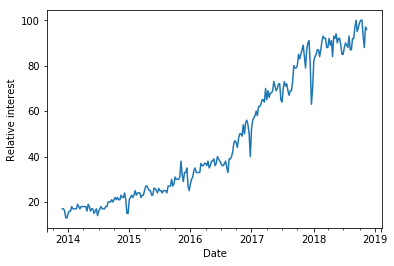

In [9]:
interest_plot = google_trends_ml.plot(x="date",
                      y="interest",
                      legend=False)
interest_plot.set_xlabel("Date")
interest_plot.set_ylabel("Relative interest")
interest_plot;

In [ ]:
fig = interest_plot.get_figure()
fig.savefig(OUTPUT_PATH / "interest-in-ml.png")

### Data preparation

#### Load preprocessed data and split into train and test

In [10]:
data = pd.read_parquet(DATA_PATH / "train_data.parquet")

In [11]:
X = data[["claps", "reading_time", "text"]]
y = np.array(data["interesting"])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3, random_state=SEED,
                                                    stratify=y)

Initialize custom evaluator and shuffle split generator to use across all modeling approaches below.

In [12]:
evaluator = CustomEvaluator(target_precision=0.8)
sss = model_selection.StratifiedShuffleSplit(n_splits=6, test_size=0.2, random_state=SEED)

#### Generate a vocabulary of words specific to the corpus

We use a list of the top 10k most frequent words in the English language obtained from [this repository](https://github.com/first20hours/google-10000-english) to identify the words specific to the corpus of block posts.

PLEASE DOWNLOAD THE `google-10000-english.txt` FROM [HERE](https://github.com/first20hours/google-10000-english) BEFORE RUNNING THIS.

In [13]:
TOP_WORDS_PATH = Path.cwd() / "resources" / "top_words"
top_10k = pd.read_table(TOP_WORDS_PATH / "google-10000-english" / "google-10000-english.txt", header=None)
top_10k_dict = {str(word).lower() : rank + 1 for rank, word in top_10k.iloc[:, 0].items()}

In [14]:
texts = data["text"].copy()

In [15]:
texts = texts.apply(lambda x: x.lower())
texts = texts.apply(lambda x: clean_apostrophe(x))
texts = texts.apply(lambda x: remove_punctuation(x))
texts = texts.apply(lambda x: fix_specific(x))

In [16]:
sentences = texts.apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
oov = check_coverage(vocab, top_10k_dict)

Found matches for 39.10% of vocab
Found matches for  89.70% of all text


In [17]:
specific_vocab = [w for w, _ in oov]

In [18]:
specific_vocab[:50]

['neuralnetwork',
 'rnn',
 'neuron',
 '1',
 'googles',
 '2',
 'tensorflow',
 'clap',
 'dataset',
 'ovation',
 'cheer',
 '3',
 'gpu',
 '0',
 'github',
 'cannot',
 'mooc',
 'facebook',
 '4',
 'cnnal',
 '10',
 'bot',
 '20',
 'derivative',
 'supervised',
 'alphago',
 'bots',
 'reinforcement',
 '8',
 'gradient',
 'sigmoid',
 '5',
 'cnns',
 'youve',
 '2017',
 'classifier',
 'backpropagation',
 'relu',
 'netflix',
 'gradientdescent',
 'twitter',
 'architectures',
 'vectors',
 'startups',
 'blockchain',
 'chatbots',
 'personalization',
 'gtx',
 'linkedin',
 'datasets']

### Data exploration

#### Summary statistics

Take a first look at the data and generate summary tables for the report

In [19]:
data.head()

,author,claps,reading_time,link,title,text,interesting
20,Justin Lee,8300,11,https://medium.com/swlh/chatbots-were-the-next...,Chatbots were the next big thing: what happene...,"Oh, how the headlines blared:\nChatbots were T...",0
65,Conor Dewey,1400,7,https://towardsdatascience.com/python-for-data...,Python for Data Science: 8 Concepts You May Ha...,If you’ve ever found yourself looking up the s...,0
109,William Koehrsen,2800,11,https://towardsdatascience.com/automated-featu...,Automated Feature Engineering in Python – Towa...,Machine learning is increasingly moving from h...,1
67,Gant Laborde,1300,7,https://medium.freecodecamp.org/machine-learni...,Machine Learning: how to go from Zero to Hero ...,If your understanding of A.I. and Machine Lear...,0
76,Emmanuel Ameisen,935,11,https://blog.insightdatascience.com/reinforcem...,Reinforcement Learning from scratch – Insight ...,Want to learn about applied Artificial Intelli...,0


In [20]:
data.shape

(130, 7)

In [21]:
data["interesting"].value_counts() / data.shape[0]

0    0.646154
1    0.353846
Name: interesting, dtype: float64

In [22]:
summary_numeric = (data[["claps", "reading_time"]]
                   .describe()
                   .round(2))
summary_numeric

,claps,reading_time
count,130.00,130.00
mean,7064.05,10.67
std,9836.08,5.61
min,10.00,3.00
25%,1500.00,7.00
50%,3300.00,9.00
75%,8450.00,13.00
max,53000.00,31.00


In [23]:
save_html(df=summary_numeric, name="summary_numeric", out=OUTPUT_PATH)

In [24]:
summary_object = data[["author", "title", "text"]].describe()
summary_object

,author,title,text
count,130,130,130
unique,102,130,130
top,Adam Geitgey,Stochastic Weight Averaging — a New Way to Get...,What is Activation Function ?\nWhy we use Acti...
freq,6,1,1


In [25]:
save_html(df=summary_object, name="summary_object", out=OUTPUT_PATH)

#### Distribution of target with respect to numerical features

In [26]:
data_base = data[["claps", "reading_time", "interesting"]]

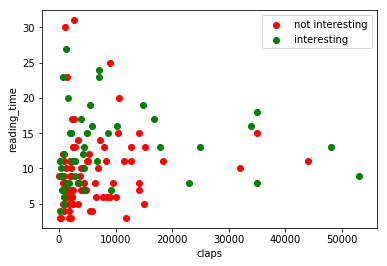

In [27]:
x_index = 0
y_index = 1
target_names = ["not interesting", "interesting"]

colors = ["red", "green"]

for label, color in zip(range(len(data_base["interesting"])), colors):
    plt.scatter(np.array(data_base[data_base["interesting"]==label].iloc[:, x_index]), 
                np.array(data_base[data_base["interesting"]==label].iloc[:, y_index]),
                label=target_names[label],
                c=color)

plt.xlabel(data_base.columns[x_index])
plt.ylabel(data_base.columns[y_index])
plt.legend(loc="upper right")

plt.savefig(OUTPUT_PATH / "base_classifier.png")

#### Distribution of blog post lengths

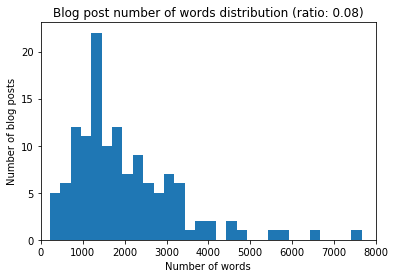

In [28]:
n_words = [len(post.split(" ")) for post in data["text"]]
words_per_review = len(data) / np.median(n_words)
plt.hist(n_words, 30)
plt.xlabel("Number of words")
plt.ylabel("Number of blog posts")
plt.xlim(0, 8000)
plt.title(f"Blog post number of words distribution (ratio: {words_per_review:.2f})")
plt.savefig(OUTPUT_PATH / "blog-post-length.png")

In [29]:
print("Summary statistics on the number of words:")
print(f"   Median: {np.median(n_words):.2f}")
print(f"   Mean: {np.mean(n_words):.2f}")
print(f"   N samples blog: {data.shape[0]}")

Summary statistics on the number of words:
   Median: 1683.50
   Mean: 1992.43
   N samples blog: 130


In [30]:
print(f"Number of samples / median number of words in each post: {words_per_review:.2f}")

Number of samples / median number of words in each post: 0.08


#### For comparison: Distribution length for imdb data

In [31]:
imdb = datasets.imdb
(train_imdb, _), (test_imdb, _) = imdb.load_data(Path.cwd() / "data" / "imdb.npz", num_words=None)

In [32]:
imdb_full = np.concatenate((train_imdb, test_imdb))

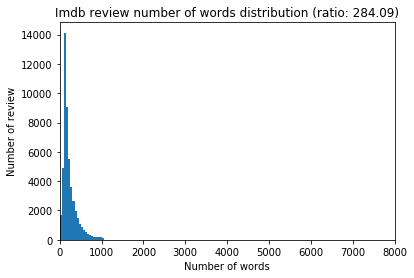

In [33]:
n_words_imdb = [len(review) for review in imdb_full]
words_per_review_imdb = imdb_full.shape[0] / np.median(n_words_imdb)
plt.hist(n_words_imdb, 50)
plt.xlabel("Number of words")
plt.ylabel("Number of review")
plt.xlim(0, 8000)
plt.title(f"Imdb review number of words distribution (ratio: {words_per_review_imdb:.2f})")
plt.savefig(OUTPUT_PATH / "imdb-review-length.png")

In [34]:
print("Summary statistics on the number of words for imdb:")
print(f"   Median: {np.median(n_words_imdb):.2f}")
print(f"   Mean: {np.mean(n_words_imdb):.2f}")
print(f"   N samples imbd: {imdb_full.shape[0]}")

Summary statistics on the number of words for imdb:
   Median: 176.00
   Mean: 234.76
   N samples imbd: 50000


In [35]:
print(f"Number of samples / median number of words in each review: {words_per_review_imdb:.2f}")

Number of samples / median number of words in each review: 284.09


### Baseline model

Create a baseline model using just the numerical features `claps` and `reading time` based on three classes of classification models:

- Random forests
- Support vector machines
- Logistic regression

In [37]:
X_train_num, X_test_num = np.array(X_train[NUM_COLS]), np.array(X_test[NUM_COLS])

#### Random Forest 

In [38]:
rf = RandomForestClassifier(n_estimators=20,
                            min_samples_leaf=3,
                            random_state=SEED)

In [39]:
fitted_rfs = fit_ensemble(rf, sss, X_train_num, y_train)

In [40]:
evaluate_ensemble(fitted_rfs, evaluator, X_test_num, y_test)

Mean Train AUC: 0.93 (+/- 0.01)
Mean OOB AUC: 0.77 (+/- 0.06)

Performance on hold out set:
AUC SCORE: 0.63
    precision    recall  threshold
16        0.5  0.642857   0.495404
18        0.5  0.571429   0.517662
22        0.5  0.428571   0.657033


In [41]:
base_results_rf = evaluate_ensemble(fitted_rfs, evaluator, X_test_num, y_test, return_res=True, method="baseline_rf")

Mean Train AUC: 0.93 (+/- 0.01)
Mean OOB AUC: 0.77 (+/- 0.06)

Performance on hold out set:
AUC SCORE: 0.63


#### Support Vector Machine

In [42]:
svc = SVC(gamma="auto",
          probability=True)

In [43]:
fitted_svcs = fit_ensemble(svc, sss, X_train_num, y_train)

In [44]:
evaluate_ensemble(fitted_svcs, evaluator, X_test_num, y_test)

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.62 (+/- 0.08)

Performance on hold out set:
AUC SCORE: 0.40
    precision    recall  threshold
13        1.0  0.071429    0.51967


In [45]:
base_results_svc = evaluate_ensemble(fitted_svcs, evaluator, X_test_num, y_test, return_res=True, method="baseline_svc")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.62 (+/- 0.08)

Performance on hold out set:
AUC SCORE: 0.40


#### Logistic regression

In [46]:
lr = LogisticRegression(solver="liblinear", random_state=SEED)

In [47]:
fitted_lrs = fit_ensemble(lr, sss, X_train_num, y_train)

In [48]:
evaluate_ensemble(fitted_lrs, evaluator, X_test_num, y_test)

Mean Train AUC: 0.71 (+/- 0.03)
Mean OOB AUC: 0.67 (+/- 0.13)

Performance on hold out set:
AUC SCORE: 0.64
    precision    recall  threshold
13   0.521739  0.857143   0.367415
12   0.500000  0.857143   0.318807
14   0.500000  0.785714   0.393729


In [49]:
base_results_lr = evaluate_ensemble(fitted_lrs, evaluator, X_test_num, y_test, return_res=True, method="baseline_lr")

Mean Train AUC: 0.71 (+/- 0.03)
Mean OOB AUC: 0.67 (+/- 0.13)

Performance on hold out set:
AUC SCORE: 0.64


#### Collect and save baseline results

In [50]:
base_results = pd.concat([base_results_rf, base_results_svc, base_results_lr], axis=0)

In [51]:
base_results

,method,mean train auc,mean cv auc,mean test auc
0,baseline_rf,0.928298,0.772817,0.625714
0,baseline_svc,1.000000,0.621032,0.397143
0,baseline_lr,0.712340,0.668651,0.637143


In [52]:
save_html(df=base_results, name="summary_baseline_results", out=OUTPUT_PATH, index=False)

### Text based models

Prepare feature array for training text based models by extracting just the column containing the blog posts' text from `X_train`.

In [53]:
X_train_text, X_test_text = np.array(X_train[TEXT_COL]), np.array(X_test[TEXT_COL])

#### CountVectorizer + Classifier

Scikit-learn's `CountVectorizer` is the simplest approach to turning the blog posts' texts into numerical matrices. It will just count the number of occurences of each token in the text and create a sparse matrix holding these counts for all posts.

##### Default values

First, let's do everything with default values to get a general feeling for how this approach performs.

In [54]:
count_vectorizer_specific = CountVectorizer(vocabulary=specific_vocab)

In [55]:
count_vectorizer = CountVectorizer()

###### Random Forest

With full vocab

In [56]:
pipe_countvec_rf = make_pipeline(count_vectorizer, RandomForestClassifier(n_estimators=10,
                                                                          random_state=SEED,
                                                                          n_jobs=-1))
fitted_countvec_rf = fit_ensemble(pipe_countvec_rf, sss, X_train_text, y_train)
res_countvec_rf_full = evaluate_ensemble(fitted_countvec_rf, evaluator, X_test_text, y_test,
                                         return_res=True, method=f"countvec rf full v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.73 (+/- 0.10)

Performance on hold out set:
AUC SCORE: 0.76


In [57]:
save_pickle(res_countvec_rf_full, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/countvec_rf_full/countvec_rf_full_v1.pkl


Only top k words specific to the corpus

In [58]:
pipe_countvec_rf_specific = make_pipeline(count_vectorizer_specific, RandomForestClassifier(n_estimators=10,
                                                                                            random_state=1,
                                                                                            n_jobs=-1))
fitted_countvec_rf_specific = fit_ensemble(pipe_countvec_rf_specific, sss, X_train_text, y_train)
res_countvec_rf_specific = evaluate_ensemble(fitted_countvec_rf_specific, evaluator, X_test_text, y_test,
                                             return_res=True, method=f"countvec rf specific v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.59 (+/- 0.10)

Performance on hold out set:
AUC SCORE: 0.73


In [59]:
save_pickle(res_countvec_rf_specific, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/countvec_rf_specific/countvec_rf_specific_v1.pkl


###### Support Vector Machine

We use scikit-learn's `StandardScaler` here as the SVC's default kernel (`rbf`) expects normalized features.

In [60]:
pipe_countvec_svc = make_pipeline(count_vectorizer, StandardScaler(with_mean=False),
                                  SVC(gamma="auto", probability=True, random_state=SEED))
fitted_countvec_svc = fit_ensemble(pipe_countvec_svc, sss, X_train_text, y_train)
res_countvec_svc_full = evaluate_ensemble(fitted_countvec_svc, evaluator, X_test_text, y_test,
                                          return_res=True, method=f"countvec svc full v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.75 (+/- 0.08)

Performance on hold out set:
AUC SCORE: 0.76


In [61]:
save_pickle(res_countvec_svc_full, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/countvec_svc_full/countvec_svc_full_v1.pkl


In [62]:
pipe_countvec_svc_specific = make_pipeline(count_vectorizer_specific,
                                           StandardScaler(with_mean=False),
                                           SVC(gamma="auto", probability=True, random_state=SEED))
fitted_countvec_svc_specific = fit_ensemble(pipe_countvec_svc_specific, sss, X_train_text, y_train)
res_countvec_svc_specific = evaluate_ensemble(fitted_countvec_svc_specific, evaluator, X_test_text, y_test,
                                              return_res=True, method=f"countvec svc specific v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.74 (+/- 0.06)

Performance on hold out set:
AUC SCORE: 0.77


In [63]:
save_pickle(res_countvec_svc_specific, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/countvec_svc_specific/countvec_svc_specific_v1.pkl


##### Grid search on best default models

###### Full vocab + SVC

In [64]:
pipe = Pipeline([
    ("vec", CountVectorizer()),
    ("std", StandardScaler(with_mean=False)),
    ("svc", SVC(probability=True))
    ])
params = {"vec__stop_words": ["english", None],
          "vec__ngram_range": [(1, 1), (1, 2), (1, 3)], 
          "vec__max_df": uniform(loc=0.8, scale=0.2),
          "vec__min_df": uniform(loc=0.0, scale=0.2),
          "vec__max_features": randint(low=1000, high=20000),
          "svc__C": scipy.stats.expon(scale=1.0),
          "svc__gamma": ["auto", "scale"],
          "svc__kernel": ["rbf"],
          "svc__class_weight": ["balanced", None]}

grid = RandomizedSearchCV(pipe,
                          params,
                          n_iter=50,
                          scoring="roc_auc",
                          cv=5,
                          return_train_score=False)

In [65]:
grid_fitted = grid.fit(X_train_text, y_train)

/home/steffen/anaconda3/envs/medium-classifier-base/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [66]:
joblib.dump(grid_fitted.best_estimator_, MODEL_PATH / "countvec_full_svc_grid_best.pkl", compress=1)

['/home/steffen/projects/medium-classifier/models/countvec_full_svc_grid_best.pkl']

In [67]:
countvec_svc_full_grid_best = joblib.load(MODEL_PATH / "countvec_full_svc_grid_best.pkl")
countvec_svc_full_grid_best = countvec_svc_full_grid_best.set_params(svc__random_state=SEED)
fitted_countvec_svc_full_grid_best = fit_ensemble(countvec_svc_full_grid_best, sss,
                                                X_train_text, y_train, print_progress=True)
res_countvec_svc_full_best = evaluate_ensemble(fitted_countvec_svc_full_grid_best, evaluator, X_test_text, y_test,
                                              return_res=True, method=f"countvec svc full best params v{SEED}") 

#######################################
Training model number   1
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.75

#######################################
Training model number   2
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.67

#######################################
Training model number   3
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.69

#######################################
Training model number   4
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.90

#######################################
Training model number   5
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.61

#######################################
Training model number   6
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.86

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.75 (+/- 0.11)

Performance on hold out set:
AUC SCORE: 0.68


In [68]:
countvec_svc_full_grid_best.get_params()

{'memory': None,
 'steps': [('vec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=0.982030025655062, max_features=4182,
           min_df=0.1265458773647938, ngram_range=(1, 3), preprocessor=None,
           stop_words='english', strip_accents=None,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)),
  ('std', StandardScaler(copy=True, with_mean=False, with_std=True)),
  ('svc',
   SVC(C=1.5288950632796479, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
     verbose=False))],
 'vec': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=0.9820300256

In [69]:
save_pickle(res_countvec_svc_full_best, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/countvec_svc_full_best_params/countvec_svc_full_best_params_v1.pkl


###### Specific vocab + SVC

In [70]:
pipe = Pipeline([
    ("vec", CountVectorizer(vocabulary=specific_vocab)),
    ("std", StandardScaler(with_mean=False)),
    ("svc", SVC(probability=True))
    ])
params = {"vec__stop_words": ["english", None],
          "vec__ngram_range": [(1, 1), (1, 2), (1, 3)], 
          "vec__max_df": uniform(loc=0.8, scale=0.2),
          "vec__min_df": uniform(loc=0.0, scale=0.2),
          "vec__max_features": randint(low=1000, high=20000),
          "svc__C": scipy.stats.expon(scale=1.0),
          "svc__gamma": ["auto", "scale"],
          "svc__kernel": ["rbf"],
          "svc__class_weight": ["balanced", None]}

grid = RandomizedSearchCV(pipe,
                          params,
                          n_iter=50,
                          scoring="roc_auc",
                          cv=5,
                          return_train_score=False)

In [71]:
grid_fitted = grid.fit(X_train_text, y_train)

/home/steffen/anaconda3/envs/medium-classifier-base/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [72]:
joblib.dump(grid_fitted.best_estimator_, MODEL_PATH / "countvec_specific_svc_grid_best.pkl", compress=1)

['/home/steffen/projects/medium-classifier/models/countvec_specific_svc_grid_best.pkl']

In [73]:
countvec_svc_specific_grid_best = joblib.load(MODEL_PATH / "countvec_specific_svc_grid_best.pkl")
countvec_svc_specific_grid_best = countvec_svc_specific_grid_best.set_params(svc__random_state=SEED)
fitted_countvec_svc_specific_grid_best = fit_ensemble(countvec_svc_specific_grid_best, sss,
                                                X_train_text, y_train, print_progress=True)
res_countvec_svc_specific_best = evaluate_ensemble(fitted_countvec_svc_specific_grid_best, evaluator, X_test_text, y_test,
                                              return_res=True, method=f"best params countvec svc specific v{SEED}") 

#######################################
Training model number   1
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.69

#######################################
Training model number   2
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.71

#######################################
Training model number   3
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.71

#######################################
Training model number   4
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.81

#######################################
Training model number   5
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.71

#######################################
Training model number   6
#######################################

TRAIN AUC: 1.00

OOB AUC: 0.83

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.75 (+/- 0.05)

Performance on hold out set:
AUC SCORE: 0.77


In [74]:
countvec_svc_specific_grid_best.get_params()

{'memory': None,
 'steps': [('vec',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=0.9688251117219239, max_features=14874,
           min_df=0.0557075597139876, ngram_range=(1, 3), preprocessor=None,
           stop_words=None, strip_accents=None,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
           vocabulary=['neuralnetwork', 'rnn', 'neuron', '1', 'googles', '2', 'tensorflow', 'clap', 'dataset', 'ovation', 'cheer', '3', 'gpu', '0', 'github', 'cannot', 'mooc', 'facebook', '4', 'cnnal', '10', 'bot', '20', 'derivative', 'supervised', 'alphago', 'bots', 'reinforcement', '8', 'gradient', 'sigmoid'...y', 'grandiose', 'monopolize', '‘overwhelming', 'headliners', 'bushytailed', 'brighteyed', 'blared'])),
  ('std', StandardScaler(copy=True, with_mean=False, with_std=True)),
  ('svc',
   SVC(C=1.140127051391354, cache_size=200, class_weight=

In [75]:
save_pickle(res_countvec_svc_specific_best, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/best_params_countvec_svc_specific/best_params_countvec_svc_specific_v1.pkl


###### Create summary of grid search results and save to html

In [76]:
list_countvec_grid = read_results(OUTPUT_PATH / "raw", "best_params_countvec*.pkl")

In [77]:
res = pd.concat(list_countvec_grid)

In [78]:
res_groupby_method = res.groupby("base_method")
res_analysis_table = res_groupby_method.agg({c : ["mean", "std"] for c in ["mean train auc", "mean cv auc", "mean test auc"]})

In [79]:
out = res_analysis_table.sort_values([("mean test auc", "mean"), ("mean cv auc", "mean")], axis=0, ascending=False)
out.index.name = None

In [80]:
index = pd.MultiIndex.from_product([["train auc", "cv auc", "test auc"], ["mean", "std"]])
out.columns = index

In [81]:
out

train auc         cv auc            \
                                       mean  std      mean       std   
best_params_countvec_svc_full           1.0  0.0  0.757143  0.053839   
best_params_countvec_svc_specific       1.0  0.0  0.775794  0.068431   

                                   test auc            
                                       mean       std  
best_params_countvec_svc_full      0.798286  0.056590  
best_params_countvec_svc_specific  0.761714  0.051965

In [82]:
save_html(out, "summary_countvec_svc_best_params", out=OUTPUT_PATH, index=True)

#### TfidfVectorizer + Classifier

The next approach to feature extraction from the text data that I want to try is the `Term-Frequency-Inverse-Document-Frequency` technique implemented in scikit-learn's `TfidfVectorizer`. This method creates the same matrix as the `CountVectorizer` but divides the values for each token in the vocabulary by its frequency across all documents in the corpus.

##### Default values

In [83]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_specific = TfidfVectorizer(vocabulary=specific_vocab)

###### Random Forest

Full vocab

In [84]:
pipe_tfidf = make_pipeline(tfidf_vectorizer, RandomForestClassifier(n_estimators=10,
                                                                    random_state=SEED,
                                                                    n_jobs=-1))
fitted_tfidf = fit_ensemble(pipe_tfidf, sss, X_train_text, y_train)
res_tfidf_rf_full = evaluate_ensemble(fitted_tfidf, evaluator, X_test_text, y_test,
                                      return_res=True, method=f"tfidf rf full v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.67 (+/- 0.14)

Performance on hold out set:
AUC SCORE: 0.79


In [85]:
save_pickle(res_tfidf_rf_full, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/tfidf_rf_full/tfidf_rf_full_v1.pkl


Only specific vocab

In [86]:
pipe_tfidf_specific = make_pipeline(tfidf_vectorizer_specific, RandomForestClassifier(n_estimators=10,
                                                                                      random_state=SEED,
                                                                                      n_jobs=-1))
fitted_tfidf_specific = fit_ensemble(pipe_tfidf_specific, sss, X_train_text, y_train)
res_tfidf_rf_specific = evaluate_ensemble(fitted_tfidf_specific, evaluator, X_test_text, y_test,
                                          return_res=True, method=f"tfidf rf specific v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.52 (+/- 0.13)

Performance on hold out set:
AUC SCORE: 0.72


In [87]:
save_pickle(res_tfidf_rf_specific, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/tfidf_rf_specific/tfidf_rf_specific_v1.pkl


###### Support Vector Machine

In [88]:
pipe_tfidf_svc = make_pipeline(tfidf_vectorizer,
                               StandardScaler(with_mean=False),
                               SVC(gamma="auto",
                                   probability=True,
                                   random_state=SEED))
fitted_tfidf_svc = fit_ensemble(pipe_tfidf_svc, sss, X_train_text, y_train)
res_tfidf_svc_full = evaluate_ensemble(fitted_tfidf_svc, evaluator, X_test_text, y_test,
                                       return_res=True, method=f"tfidf svc full v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.47 (+/- 0.11)

Performance on hold out set:
AUC SCORE: 0.62


In [89]:
save_pickle(res_tfidf_svc_full, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/tfidf_svc_full/tfidf_svc_full_v1.pkl


In [90]:
pipe_tfidf_svc_specific = make_pipeline(tfidf_vectorizer_specific,
                                        StandardScaler(with_mean=False),
                                        SVC(gamma="auto",
                                            probability=True,
                                            random_state=SEED))
fitted_tfidf_svc_specific = fit_ensemble(pipe_tfidf_svc_specific, sss, X_train_text, y_train)
res_tfidf_svc_specific = evaluate_ensemble(fitted_tfidf_svc_specific, evaluator, X_test_text, y_test,
                                           return_res=True, method=f"tfidf svc specific v{SEED}")

Mean Train AUC: 1.00 (+/- 0.00)
Mean OOB AUC: 0.62 (+/- 0.13)

Performance on hold out set:
AUC SCORE: 0.55


In [91]:
save_pickle(res_tfidf_svc_specific, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/tfidf_svc_specific/tfidf_svc_specific_v1.pkl


##### Collect results from running the above with different seeds

In [92]:
list_countvec = read_results(OUTPUT_PATH / "raw", "countvec*.pkl")

In [93]:
list_tfidf = read_results(OUTPUT_PATH / "raw", "tfidf*.pkl")

In [94]:
results_tfidf_countvec = pd.concat([e for l in [list_countvec, list_tfidf] for e in l])

In [95]:
results_tfidf_countvec

,method,mean train auc,mean cv auc,mean test auc,base_method
0,countvec rf full v1,0.999433,0.731151,0.762857,countvec_rf_full
0,countvec rf full v2,0.999929,0.697421,0.678571,countvec_rf_full
0,countvec rf full v3,0.999220,0.734127,0.827143,countvec_rf_full
0,countvec rf full v4,0.999149,0.760913,0.751429,countvec_rf_full
0,countvec rf full v5,0.999929,0.646825,0.735714,countvec_rf_full
0,countvec rf specific v1,0.999504,0.594246,0.728571,countvec_rf_specific
0,countvec rf specific v2,0.999929,0.636905,0.847143,countvec_rf_specific
0,countvec rf specific v3,0.999716,0.673611,0.731429,countvec_rf_specific
0,countvec rf specific v4,1.000000,0.689484,0.670000,countvec_rf_specific
0,countvec rf specific v5,0.999787,0.641865,0.765714,countvec_rf_specific


In [96]:
save_html(df=results_tfidf_countvec.drop("base_method", axis=1).sort_values(["mean test auc", "mean cv auc"], axis=0, ascending=False),
          name="countvec_tfidf_results_default_all_appendix",
          out=OUTPUT_PATH,
          index=False)

##### Summarize results and save overview table

In [97]:
res = results_tfidf_countvec.sort_values(["mean test auc", "mean cv auc"], axis=0, ascending=False)

In [98]:
res_groupby_method = res.groupby("base_method")
res_analysis_table = res_groupby_method.agg({c : ["mean", "std"] for c in ["mean train auc", "mean cv auc", "mean test auc"]})

In [99]:
out = res_analysis_table.sort_values([("mean test auc", "mean"), ("mean cv auc", "mean")], axis=0, ascending=False)
out.index.name = None

In [100]:
index = pd.MultiIndex.from_product([["train auc", "cv auc", "test auc"], ["mean", "std"]])
out.columns = index

In [101]:
out

train auc              cv auc            \
                                   mean       std      mean       std   
countvec_svc_full              1.000000  0.000000  0.737302  0.043687   
countvec_svc_specific          0.999858  0.000201  0.773413  0.067830   
countvec_rf_full               0.999532  0.000377  0.714087  0.043839   
tfidf_rf_full                  0.999191  0.000374  0.665079  0.027228   
countvec_rf_specific           0.999787  0.000194  0.647222  0.036824   
tfidf_rf_specific              0.999518  0.000373  0.611111  0.075511   
countvec_svc_full_best_params  1.000000       NaN  0.746032       NaN   
tfidf_svc_specific             0.999972  0.000063  0.612302  0.040012   
tfidf_svc_full                 0.833333  0.288675  0.529167  0.068083   

                               test auc            
                                   mean       std  
countvec_svc_full              0.788000  0.064504  
countvec_svc_specific          0.754286  0.059625  
countvec_rf_full               0.751143  0.053427  
tfidf_rf_full                  0.748857  0.069645  
countvec_rf_specific           0.748571  0.064957  
tfidf_rf_specific              0.715429  0.059087  
countvec_svc_full_best_params  0.680000       NaN  
tfidf_svc_specific             0.490286  0.086958  
tfidf_svc_full                 0.466857  0.093167

In [102]:
save_html(df=out,
          name="summary_countvec_tfidf_results_default",
          out=OUTPUT_PATH,
          index=True)

#### Pretrained word embeddings + neural network 

The below is heavily based on these two Kaggle Kernels:
- [Processing text when using word embeddings](https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings/notebook)
- [Comparing word embeddings](https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings/notebook)

##### Config

In [103]:
text_len = data["text"].apply(lambda x: len(x.split(" ")))
text_para_len = data["text"].apply(lambda x: len(x.split("\n")))

In [104]:
print(f"There are {len(vocab)} distinct words in the blog posts.")
print()
print("Summary statistics on the number of words across all blog posts:")
print(f"   Mean: {text_len.mean():.2f}")
print(f"   Median: {text_len.median():.2f}")
print(f"   Maximum: {text_len.max()}")
print(f"   Minimum: {text_len.min()}")
print(f"   Standard deviation: {text_len.std():.2f}")
print()
print("Summary statistics on the number of paragraphs across all blog posts:")
print(f"   Mean: {text_para_len.mean():.2f}")
print(f"   Median: {text_para_len.median():.2f}")
print(f"   Maximum: {text_para_len.max()}")
print(f"   Minimum: {text_para_len.min()}")
print(f"   Standard deviation: {text_para_len.std():.2f}")

There are 16085 distinct words in the blog posts.

Summary statistics on the number of words across all blog posts:
   Mean: 1992.43
   Median: 1683.50
   Maximum: 7661
   Minimum: 210
   Standard deviation: 1266.78

Summary statistics on the number of paragraphs across all blog posts:
   Mean: 48.55
   Median: 41.00
   Maximum: 166
   Minimum: 9
   Standard deviation: 27.78


In [105]:
MAX_FEATURES = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_LEN = 1000 # max number of words in a blog post
EMBEDDING_PATH = Path.cwd() / "resources" / "embeddings"
EMBEDDING_FOLDER = EMBEDDING_PATH / "glove.840B.300d"
SPECIFIC_ONLY = False
L2_REG = None

##### Read embeddings

In [106]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype="float32")

PLEASE DOWNLOAD THE GLOVE WORD EMBEDDINGS, FOR EXAMPLE FROM [HERE](https://www.kaggle.com/c/quora-insincere-questions-classification/data) BEFORE RUNNING THIS.

In [107]:
if (EMBEDDING_FOLDER / "embeddings_index.pkl").is_file():
    with open(EMBEDDING_FOLDER / "embeddings_index.pkl", "rb") as handle:
        embeddings_index = pickle.load(handle)
else:
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FOLDER / "glove.840B.300d.txt"))
    with open(EMBEDDING_FOLDER / "embeddings_index.pkl", "wb") as handle:
        pickle.dump(embeddings_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### Preprocess the text data to work well with embeddings

In [108]:
X_train = pd.Series(X_train_text.copy())
X_test = pd.Series(X_test_text.copy())

In [109]:
X_train = X_train.apply(lambda x: x.lower())
X_train = X_train.apply(lambda x: clean_apostrophe(x))
X_test = X_train.apply(lambda x: fix_punctuation(x))
X_train = X_train.apply(lambda x: fix_specific(x))

Apply the same transformations to the test set

In [110]:
X_test = X_test.apply(lambda x: x.lower())
X_test = X_test.apply(lambda x: clean_apostrophe(x))
X_test = X_test.apply(lambda x: fix_punctuation(x))
X_test = X_test.apply(lambda x: fix_specific(x))

##### Tokenize the texts 

In [111]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_train))

In [112]:
X_train = tokenizer.texts_to_sequences(X_train_text)
X_test = tokenizer.texts_to_sequences(X_test_text)

In [113]:
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)

##### Process embeddings into a matrix of size `(max_features, embed_size)`

In [114]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

In [115]:
word_index = tokenizer.word_index

if SPECIFIC_ONLY: word_index = {word : i for word, i in word_index.items() if word in specific_vocab}

In [116]:
nb_words = min(MAX_FEATURES, len(tokenizer.word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= MAX_FEATURES: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

##### Define model

In [117]:
from keras import regularizers
reg = regularizers.l2(L2_REG) if L2_REG else None

In [118]:
inp = Input(shape=(MAX_LEN,))
x = Embedding(MAX_FEATURES, embed_size, weights=[embedding_matrix], embeddings_regularizer=reg)(inp)
x = Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=reg))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu", kernel_regularizer=reg)(x)
x = Dropout(0.6)(x)
x = Dense(1, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 128)         140160    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total para

##### Fit model

In [119]:
from keras.callbacks import EarlyStopping

In [121]:
model.fit(X_train, y_train, batch_size=16, epochs=10,
          validation_data=(X_test, y_test), callbacks=[EarlyStopping(min_delta=0.005, patience=2, restore_best_weights=True)])

Train on 91 samples, validate on 39 samples
Epoch 1/10
91/91 [==============================] - 11s 116ms/step - loss: 0.7199 - acc: 0.5385 - val_loss: 0.6502 - val_acc: 0.6410
Epoch 2/10
91/91 [==============================] - 11s 120ms/step - loss: 0.5842 - acc: 0.6703 - val_loss: 0.6418 - val_acc: 0.6410
Epoch 3/10
91/91 [==============================] - 10s 114ms/step - loss: 0.5512 - acc: 0.6264 - val_loss: 0.6419 - val_acc: 0.6410
Epoch 4/10
91/91 [==============================] - 10s 114ms/step - loss: 0.4729 - acc: 0.8352 - val_loss: 0.6459 - val_acc: 0.6667


##### Evaluate model

In [122]:
train_auc = metrics.roc_auc_score(y_train, model.predict(X_train))
test_auc = metrics.roc_auc_score(y_test, model.predict(X_test))

In [123]:
results_keras = pd.DataFrame({"method": f"embeddings keras v{SEED}", "train auc": train_auc, "test auc": test_auc},
                             index=[0])

In [124]:
results_keras

,method,train auc,test auc
0,embeddings keras v1,0.992585,0.557143


In [125]:
save_pickle(results_keras, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/embeddings_keras/embeddings_keras_v1.pkl


##### Collect results and save for report

In [126]:
list_keras = read_results(OUTPUT_PATH / "raw", "*keras*.pkl")

In [127]:
full_results_keras = pd.concat(list_keras)

In [128]:
full_results_keras

,method,train auc,test auc,base_method
0,embeddings keras v1,0.992585,0.557143,embeddings_keras
0,embeddings keras v2,0.882415,0.494286,embeddings_keras
0,embeddings keras v3,0.952860,0.668571,embeddings_keras
0,embeddings keras v4,0.930614,0.677143,embeddings_keras
0,embeddings keras v5,0.969280,0.608571,embeddings_keras


In [129]:
save_html(df=full_results_keras.drop("base_method", axis=1).sort_values(["test auc"], axis=0, ascending=False),
          name="keras_results_all_appendix",
          out=OUTPUT_PATH,
          index=False)

Aggregate results and save for report

In [130]:
res = full_results_keras.groupby("base_method").agg({c : ["mean", "std"] for c in ["train auc", "test auc"]})

In [131]:
out = res.sort_values([("test auc", "mean")], axis=0, ascending=False)
out.index.name = None

In [132]:
index = pd.MultiIndex.from_product([["train auc", "test auc"], ["mean", "std"]])
out.columns = index

In [133]:
out

train auc            test auc          
                      mean       std      mean       std
embeddings_keras  0.945551  0.041946  0.601143  0.077026

In [134]:
save_html(df=out,
          name="keras_results_summary",
          out=OUTPUT_PATH,
          index=True)

#### Language model + neural network

IT IS HIGHLY RECOMMENDED TO USE A GPU TO RUN THE FOLLOWING. 

In [136]:
from fastai.datasets import URLs
from fastai.text import TextList
from fastai.basic_data import DatasetType
from fastai.text.learner import text_classifier_learner
from fastai.text.learner import language_model_learner

In [137]:
PATH = MODEL_PATH / "fastai"
if not PATH.is_dir():
    PATH.mkdir(parents=True)

In [138]:
MIN_N_TOKENS = 0
BPTT = 1000
MAX_LEN = 2000
SPLIT_TEXTS = False

Optionally, we split the long texts into chunks based on new line characters, train on those and put the results back together in the end

In [139]:
X_train_full = pd.DataFrame({"text": X_train_text, "label": y_train})
X_test_full = pd.DataFrame({"text": X_test_text, "label": y_test})

if SPLIT_TEXTS:
    X_train_full_exploded = explode_texts(X_train_full)
    X_test_full_exploded = explode_texts(X_test_full)

    X_train_full_exploded["is_test"] = False
    X_test_full_exploded["is_test"] = True

    data_proc = pd.concat([X_train_full_exploded, X_test_full_exploded], axis=0)
else:
    X_train_full["is_test"] = False
    X_test_full["is_test"] = True
    data_proc = pd.concat([X_train_full, X_test_full], axis=0)
    
n_tokens = data_proc["text"].apply(lambda x: len(x.split(" ")))

print("Summary statistics on the number of words across all blog posts:")
print(f"   Mean: {n_tokens.mean():.2f}")
print(f"   Median: {n_tokens.median():.2f}")
print(f"   Maximum: {n_tokens.max()}")
print(f"   Minimum: {n_tokens.min()}")
print(f"   Standard deviation: {n_tokens.std():.2f}")

Summary statistics on the number of words across all blog posts:
   Mean: 1992.43
   Median: 1683.50
   Maximum: 7661
   Minimum: 210
   Standard deviation: 1266.78


In [140]:
data_proc.head()

,text,label,is_test
0,There were many advances in Deep Learning and ...,0,False
1,"A bit long, but I think it might help people u...",0,False
2,Update: This article is part of a series. Chec...,0,False
3,By Bar Ifrach\nAt Airbnb we seek to match peop...,1,False
4,Last year I set a goal to learn something new ...,0,False


In [141]:
data_proc.shape

(130, 3)

##### Train and Evaluate the Language Model (Metric : Accuracy)

In [ ]:
data_lm = (TextList.from_df(df=data_proc, path=PATH, cols="text")
             .random_split_by_pct(0.2)
             .label_for_lm()
             .databunch())

In [ ]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, bptt=BPTT, drop_mult=0.5)

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
lr = 5e-2

In [ ]:
learn.fit_one_cycle(2, lr, moms=(0.8, 0.7))

In [ ]:
learn.save("lm_fit_head")

In [ ]:
learn.load("lm_fit_head");

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, lr/10, moms=(0.8, 0.7))

In [ ]:
learn.save("lm_fine_tuned")

In [ ]:
learn.save_encoder("lm_fine_tuned_enc")

##### Train and Evaluate the Classifier (Metric = ROC AUC)

###### Setup

In [ ]:
clf_df = data_proc.copy()[n_tokens >= MIN_N_TOKENS]

In [ ]:
clf_df.shape

In [ ]:
data_clf = (TextList.from_df(df=clf_df, path=PATH, cols=["text"], vocab=data_lm.vocab)
               .split_from_df("is_test")
               .label_from_df(cols="label")
               .databunch(bs=8))

In [ ]:
clf_df.head()

In [ ]:
data_clf.show_batch()

###### Training

In [ ]:
learn = text_classifier_learner(data_clf, bptt=BPTT, max_len=MAX_LEN, drop_mult=0.3)
learn.load_encoder("lm_fine_tuned_enc")
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot();

In [ ]:
lr = 5e-3

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8, 0.7))

In [ ]:
learn.save("clf_first_stage")

In [ ]:
learn.load("clf_first_stage");

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=(0.8, 0.7))

In [ ]:
learn.save("clf_second_stage")

In [ ]:
learn.load("clf_second_stage");

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice((lr/5)/(2.6**4), lr/5), moms=(0.8, 0.7))

In [ ]:
learn.save("clf_third_stage")

In [ ]:
learn.load("clf_third_stage");

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice((lr/10)/(2.6**4), lr/10), moms=(0.8, 0.7))

###### Evaluation

In [ ]:
p1_test = clf_df.loc[clf_df.is_test == True, "text"].apply(lambda t: learn.predict(t)[2].numpy()[1])

In [ ]:
p1_train = clf_df.loc[clf_df.is_test == False, "text"].apply(lambda t: learn.predict(t)[2].numpy()[1])

In [ ]:
#This doesn't seem to produce results consistent with what we get when explicitly calling predict on each sample
#I do need to finish this assignment before looking into this more closely
#Thus, I will use the slower version above for now
#p1_test = learn.get_preds()[0][:, 1].numpy()
#p1_train = learn.get_preds(ds_type=DatasetType.Train)[0][:, 1].numpy()

In [ ]:
if SPLIT_TEXTS:
    print("TRAIN PERFORMANCE")
    evaluate_exploded(clf_df[clf_df.is_test == False], p1_train, y_train)
    print()
    print("TEST PERFORMANCE")
    evaluate_exploded(clf_df[clf_df.is_test == True], p1_test, y_test)
else:
    print("TRAIN PERFORMANCE")
    train_auc = metrics.roc_auc_score(clf_df.loc[clf_df.is_test == False, "label"], p1_train)
    print(f"AUC: {train_auc:.2f}")
    print()
    print("TEST PERFORMANCE")
    test_auc = metrics.roc_auc_score(clf_df.loc[clf_df.is_test == True, "label"], p1_test)
    print(f"AUC: {test_auc:.2f}")
    results_lm_finetune = pd.DataFrame({"method": f"lm fine tuning v{SEED}", "train auc": train_auc, "test auc": test_auc},
                         index=[0])

In [ ]:
results_lm_finetune

In [ ]:
save_pickle(results_lm_finetune, OUTPUT_PATH)

Collect results and save for report

In [ ]:
list_lm_finetune = read_results(OUTPUT_PATH, "*lm*.pkl")

In [ ]:
full_results_lm_finetune = pd.concat(list_lm_finetune)

In [ ]:
full_results_lm_finetune

In [ ]:
save_html(df=full_results_lm_finetune.drop("base_method", axis=1).sort_values(["test auc"], axis=0, ascending=False),
          name="lm_finetune_results_all_appendix",
          out=OUTPUT_PATH,
          index=False)

Summarize results and save summary

In [ ]:
res = full_results_lm_finetune.groupby("base_method").agg({c : ["mean", "std"] for c in ["train auc", "test auc"]})

In [ ]:
out = res.sort_values([("test auc", "mean")], axis=0, ascending=False)
out.index.name = None

In [ ]:
index = pd.MultiIndex.from_product([["train auc", "test auc"], ["mean", "std"]])
out.columns = index

In [ ]:
out

In [ ]:
save_html(df=out,
          name="lm_finetune_results_summary",
          out=OUTPUT_PATH,
          index=True)

#### Google's guide for text classification

The below is based on the [this guide](https://developers.google.com/machine-learning/guides/text-classification/) was attempted after all of the above had been experimented with. Google's guide to building a text classifier suggests a simple heuristic to decide whether to use n-gram based approaches (e.g. those illustrated in 6.1 and 6.2) or sequence based approaches (e.g. using recurrent neural networks as showcased in chapters 6.3 and 6.4):

`if number of samples/number of words per sample < 1500 tokenize as n-grams and use an MLP (or boosted tree, SVM) to classifiy`

`if > 1500 tokenize as sequences and use a sequence model (CNN, RNN) to classify, potentially building on pretrained word embeddings`

As in our case the articles are rather long and we have just a small number of samples, we will follow the first approach.

##### Tokenize texts as unigrams and bigrams with feature selection

In [142]:
X_train_text_vec, X_test_text_vec = ngram_vectorize(X_train_text, y_train, X_test_text)

##### Build and train an MLP model

In [143]:
data_in = ((X_train_text, y_train), (X_test_text, y_test))
model = tf_helpers.train_ngram_model(data_in,
                          batch_size=8,
                          dropout_rate=0.3,
                          learning_rate=5e-4,
                          units=32)

Train on 91 samples, validate on 39 samples
Epoch 1/1000
 - 1s - loss: 0.6908 - acc: 0.5495 - val_loss: 0.6841 - val_acc: 0.6410
Epoch 2/1000
 - 0s - loss: 0.6684 - acc: 0.6703 - val_loss: 0.6740 - val_acc: 0.6410
Epoch 3/1000
 - 0s - loss: 0.6422 - acc: 0.6813 - val_loss: 0.6641 - val_acc: 0.6410
Epoch 4/1000
 - 0s - loss: 0.6134 - acc: 0.7912 - val_loss: 0.6555 - val_acc: 0.6410
Epoch 5/1000
 - 0s - loss: 0.5760 - acc: 0.8132 - val_loss: 0.6452 - val_acc: 0.6410
Epoch 6/1000
 - 0s - loss: 0.5367 - acc: 0.8681 - val_loss: 0.6367 - val_acc: 0.6410
Epoch 7/1000
 - 0s - loss: 0.5031 - acc: 0.9560 - val_loss: 0.6296 - val_acc: 0.6410
Epoch 8/1000
 - 0s - loss: 0.4609 - acc: 0.9890 - val_loss: 0.6219 - val_acc: 0.6667
Epoch 9/1000
 - 0s - loss: 0.4253 - acc: 0.9890 - val_loss: 0.6146 - val_acc: 0.6923
Epoch 10/1000
 - 0s - loss: 0.3923 - acc: 0.9890 - val_loss: 0.6074 - val_acc: 0.6923
Epoch 11/1000
 - 0s - loss: 0.3572 - acc: 1.0000 - val_loss: 0.5986 - val_acc: 0.6923
Epoch 12/1000
 - 0s

In [144]:
metrics.roc_auc_score(y_train, model.predict(X_train_text_vec))

1.0

In [145]:
metrics.roc_auc_score(y_test, model.predict(X_test_text_vec))

0.8714285714285713

### Final evaluation

#### Run for different random seeds

Run best model for different seeds and save resulting auc, precision, and recall.

In [151]:
best_model = joblib.load(MODEL_PATH / "countvec_full_svc_grid_best.pkl").set_params(svc__random_state=SEED)

In [152]:
best_model.fit(X_train_text, y_train)

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.982030025655062, max_features=4182,
        min_df=0.1265458773647938, ngram_range=(1, 3), preprocessor=None,
...rbf',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False))])

In [153]:
res_best = get_best_scores(y_test, best_model.predict_proba(X_test_text)[:, 1], f"final_model_svc_countvec_full_v{SEED}")

/home/steffen/anaconda3/envs/medium-classifier-base/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [154]:
res_best

,method,roc_auc,threshold,precision,recall,f_0.8
0,final_model_svc_countvec_full_v1,0.72,0.365027,0.481481,0.928571,0.60984


In [155]:
save_pickle(res_best, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/final_model_svc_countvec_full/final_model_svc_countvec_full_v1.pkl


Run best benchmark model as a point of comparison.

In [157]:
lr = LogisticRegression(solver="liblinear", random_state=SEED)
lr.fit(X_train_num, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [159]:
res_base = get_best_scores(y_test, lr.predict_proba(X_test_num)[:, 1], f"baseline_model_lr_v{SEED}")

In [160]:
res_base

,method,roc_auc,threshold,precision,recall,f_0.8
0,baseline_model_lr_v1,0.64,0.315321,0.5,0.857143,0.61577


In [161]:
save_pickle(res_base, OUTPUT_PATH)

Saved results to file at: /home/steffen/projects/medium-classifier/reports/images-and-tables/raw/baseline_model_lr/baseline_model_lr_v1.pkl


#### Collect and summarize results

In [162]:
list_best = read_results(OUTPUT_PATH / "raw", "final_model*.pkl")
full_res_best = pd.concat(list_best)

In [163]:
full_res_best

,method,roc_auc,threshold,precision,recall,f_0.8,base_method
0,final_model_svc_countvec_full_v1,0.720000,0.365027,0.481481,0.928571,0.609840,final_model_svc_countvec_full
0,final_model_svc_countvec_full_v2,0.765714,0.542546,0.727273,0.571429,0.691983,final_model_svc_countvec_full
0,final_model_svc_countvec_full_v3,0.885714,0.579919,0.714286,0.714286,0.746812,final_model_svc_countvec_full
0,final_model_svc_countvec_full_v4,0.805714,0.403528,0.590909,0.928571,0.711615,final_model_svc_countvec_full
0,final_model_svc_countvec_full_v5,0.811429,0.548128,0.750000,0.642857,0.739479,final_model_svc_countvec_full


In [164]:
list_base = read_results(OUTPUT_PATH / "raw", "baseline_model*.pkl")
full_res_base = pd.concat(list_base)

In [165]:
full_res_base

,method,roc_auc,threshold,precision,recall,f_0.8,base_method
0,baseline_model_lr_v1,0.640000,0.315321,0.500000,0.857143,0.615770,baseline_model_lr
0,baseline_model_lr_v2,0.685714,0.285543,0.461538,0.857143,0.579505,baseline_model_lr
0,baseline_model_lr_v3,0.808571,0.394291,0.642857,0.642857,0.672131,baseline_model_lr
0,baseline_model_lr_v4,0.734286,0.379447,0.600000,0.642857,0.642857,baseline_model_lr
0,baseline_model_lr_v5,0.688571,0.277611,0.464286,0.928571,0.592881,baseline_model_lr


In [166]:
res = pd.concat([full_res_base, full_res_best])

In [167]:
res.drop("base_method", axis=1).sort_values("f_0.8", ascending=False)

,method,roc_auc,threshold,precision,recall,f_0.8
0,final_model_svc_countvec_full_v3,0.885714,0.579919,0.714286,0.714286,0.746812
0,final_model_svc_countvec_full_v5,0.811429,0.548128,0.750000,0.642857,0.739479
0,final_model_svc_countvec_full_v4,0.805714,0.403528,0.590909,0.928571,0.711615
0,final_model_svc_countvec_full_v2,0.765714,0.542546,0.727273,0.571429,0.691983
0,baseline_model_lr_v3,0.808571,0.394291,0.642857,0.642857,0.672131
0,baseline_model_lr_v4,0.734286,0.379447,0.600000,0.642857,0.642857
0,baseline_model_lr_v1,0.640000,0.315321,0.500000,0.857143,0.615770
0,final_model_svc_countvec_full_v1,0.720000,0.365027,0.481481,0.928571,0.609840
0,baseline_model_lr_v5,0.688571,0.277611,0.464286,0.928571,0.592881
0,baseline_model_lr_v2,0.685714,0.285543,0.461538,0.857143,0.579505


Save raw results

In [168]:
save_html(res.drop("base_method", axis=1).sort_values("f_0.8", ascending=False), "final_evaluation_raw_appendix", OUTPUT_PATH)

Aggregate results and save to file

In [169]:
summary = (res
          .groupby("base_method")
          .agg({c : ["mean", "std"] for c in ["roc_auc", "precision", "recall", "f_0.8"]}))

In [170]:
summary

roc_auc           precision            \
                                   mean       std      mean       std   
base_method                                                             
baseline_model_lr              0.711429  0.063728  0.533736  0.082874   
final_model_svc_countvec_full  0.797714  0.061359  0.652790  0.113968   

                                 recall               f_0.8            
                                   mean       std      mean       std  
base_method                                                            
baseline_model_lr              0.785714  0.133631  0.620629  0.037521  
final_model_svc_countvec_full  0.757143  0.164441  0.699946  0.054950

In [171]:
summary.index.name = None
index = pd.MultiIndex.from_product([["roc auc", "precision", "recall", "f_0.8"], ["mean", "std"]])
summary.columns = index

In [172]:
summary.T

baseline_model_lr  final_model_svc_countvec_full
roc auc   mean           0.711429                       0.797714
          std            0.063728                       0.061359
precision mean           0.533736                       0.652790
          std            0.082874                       0.113968
recall    mean           0.785714                       0.757143
          std            0.133631                       0.164441
f_0.8     mean           0.620629                       0.699946
          std            0.037521                       0.054950

In [173]:
save_html(summary.T, "final_evaluation_summary", OUTPUT_PATH)